In [180]:
import json
import gzip
from tqdm import tqdm
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
import matplotlib.pyplot as plt
from pandas import DataFrame as df
import sys
import numpy as np

from rake_nltk import Rake

In [181]:
i = 0
list_of_q = []
with gzip.open('nq.jsonl.gz') as f:
    for line in tqdm(f):
        if i > 100 and i < 1100:
            list_of_q.append(line)
        i += 1

7830it [00:17, 445.19it/s]


In [117]:
l = list_of_q[20]
x = json.loads(l)

In [219]:
display(x.keys())
display(x['annotations'][0].keys())
display(x['document_tokens'][0].keys())
display(x['long_answer_candidates'][0].keys())
display(x['question_text'])
display(x['document_url'])

dict_keys(['annotations', 'document_html', 'document_title', 'document_tokens', 'document_url', 'example_id', 'long_answer_candidates', 'question_text', 'question_tokens'])

dict_keys(['annotation_id', 'long_answer', 'short_answers', 'yes_no_answer'])

dict_keys(['end_byte', 'html_token', 'start_byte', 'token'])

dict_keys(['end_byte', 'end_token', 'start_byte', 'start_token', 'top_level'])

'when did the 49ers last won a superbowl'

'https://en.wikipedia.org//w/index.php?title=Seattle_Seahawks&amp;oldid=838456148'

In [132]:
[y['token'] for y in x['document_tokens'][30:532]]

['<Table>',
 '<Tr>',
 '<Th colspan="2">',
 'Seattle',
 'Seahawks',
 '</Th>',
 '</Tr>',
 '<Tr>',
 '<Td colspan="2">',
 'Current',
 'season',
 '</Td>',
 '</Tr>',
 '<Tr>',
 '<Td colspan="2">',
 'Established',
 'June',
 '4',
 ',',
 '1974',
 ';',
 '43',
 'years',
 'ago',
 '(',
 '1974',
 '-',
 '06',
 '-',
 '04',
 ')',
 'First',
 'season',
 ':',
 '1976',
 'Play',
 'in',
 'CenturyLink',
 'Field',
 'Seattle',
 ',',
 'Washington',
 'Headquartered',
 'in',
 'the',
 'Virginia',
 'Mason',
 'Athletic',
 'Center',
 'Renton',
 ',',
 'Washington',
 '</Td>',
 '</Tr>',
 '<Tr>',
 '<Th colspan="2">',
 '</Th>',
 '</Tr>',
 '<Tr>',
 '<Td colspan="2">',
 '<Table>',
 '<Tr>',
 '<Td>',
 '</Td>',
 '<Td>',
 '</Td>',
 '</Tr>',
 '<Tr>',
 '<Td>',
 'Logo',
 '</Td>',
 '<Td>',
 'Wordmark',
 '</Td>',
 '</Tr>',
 '</Table>',
 '</Td>',
 '</Tr>',
 '<Tr>',
 '<Th colspan="2">',
 'League',
 '/',
 'conference',
 'affiliations',
 '</Th>',
 '</Tr>',
 '<Tr>',
 '<Td colspan="2">',
 '<P>',
 'National',
 'Football',
 'League',
 '(',
 '

In [119]:
x['annotations']

[{'annotation_id': 5652942812737956535,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 7508345935899274474,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 4780625526650654850,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 13347808338101537992,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 15961978642434181346,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -

In [120]:
answer = x['document_html'].encode('utf-8')[70812:70823].decode('utf-8')

In [202]:
pytrends = TrendReq(hl='en-US', tz=300, timeout=(10,25), retries=10, backoff_factor=0.001, requests_args={'verify':True})

In [122]:
kw_list = [answer]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='', gprop='')

In [74]:
trend =pytrends.interest_over_time()

In [75]:
trend

""


In [123]:
r = Rake()
r.extract_keywords_from_text(x['question_text'])
kw_list = r.get_ranked_phrases()
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='', gprop='')

In [124]:
trend = pytrends.interest_over_time()

trend = trend - trend.mean()
trend = trend.drop(['isPartial'], axis=1)

<AxesSubplot:xlabel='date'>

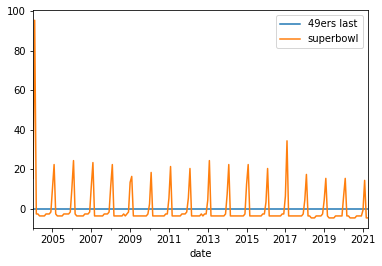

In [125]:
trend.plot()

In [140]:
def get_short_answers(question):
    answers = set()
    for annotation in question['annotations']:
        if len(annotation['short_answers']) != 0:
            short_answer = annotation['short_answers'][0]
            answer = question['document_html'].encode('utf-8')[short_answer['start_byte']:short_answer['end_byte']].decode('utf-8')
            answers.add(answer)
    return list(answers)
            
            
print(json.loads(l)['annotations'][0]['short_answers'])
print(get_short_answer(json.loads(l)))

[]
[]


In [196]:
def get_trend(question, normalize=False):
    short_answers = get_short_answer(question)
    r = Rake()
    r.extract_keywords_from_text(question['question_text'])
    
    question_keywords = r.get_ranked_phrases()
    

    # Get trend data of answers and question keywords
    try:
        pytrends.build_payload(short_answers, cat=0, timeframe='all', geo='', gprop='')
        answer_trends = pytrends.interest_over_time()
    except ResponseError as e:
        print(e.response)
        return df(), df()
    
    

    
    try:
        pytrends.build_payload(question_keywords, cat=0, timeframe='all', geo='', gprop='')
        question_trends = pytrends.interest_over_time()
    except ResponseError as e:
        print(e.response)
        return df(), df()
            
    
    if normalize:
        if 'isPartial' in answer_trends.columns:
            answer_trends = answer_trends.drop(['isPartial'], axis=1)
        if 'isPartial' in question_trends.columns:    
            question_trends =question_trends.drop(['isPartial'], axis=1)
        answer_trends = answer_trends - answer_trends.mean()
        question_trends = question_trends - question_trends.mean()
    
    
    return question_trends, answer_trends
    

<AxesSubplot:xlabel='date'>

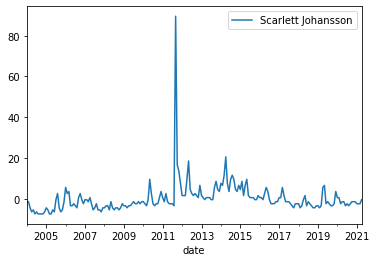

In [197]:
a.plot()

In [198]:
combined = q.merge(a, left_on='date', right_on='date')

In [199]:
combined.corr()['Scarlett Johansson'][:-1].max()

0.2982669074168234

KeyError: 'Tamara Drasin'

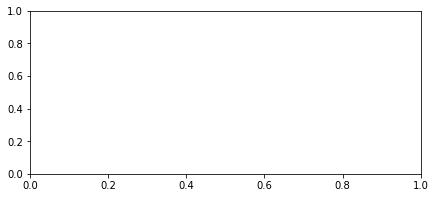

In [200]:
overall_pearson_r = combined.corr().iloc[0,2]

f,ax=plt.subplots(figsize=(7,3))
display(combined['Tamara Drasin'].rolling(window=1,center=True).corr(combined['eyes first']))
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

In [203]:
def get_maximum_correlations(list_of_questions):
    texts = []
    correlations = []
    for question in tqdm(list_of_questions):
        question = json.loads(question)
        short_answers = get_short_answers(question)
        if len(short_answers) != 0:
            question_trend, answer_trend = get_trend(question, normalize=True)
            
            if not answer_trend.empty and not question_trend.empty:
                #display(answer_trend)
                combined = question_trend.merge(answer_trend, left_on='date', right_on='date')
               # display(combined.corr())
                short_answer_corr = combined.corr().iloc[:-len(short_answers),-len(short_answers):]
                max_corr = np.nanmax(short_answer_corr)
                texts.append(question['question_text'])
                correlations.append(max_corr)
            
    return texts, correlations
t, c, = get_maximum_correlations(list_of_q)

c
    
    

  3%|▎         | 27/999 [00:04<02:44,  5.91it/s]

<Response [400]>
<Response [400]>
<Response [400]>


  3%|▎         | 29/999 [00:05<03:32,  4.57it/s]

<Response [400]>


  3%|▎         | 31/999 [00:06<04:04,  3.96it/s]

<Response [400]>


  4%|▍         | 43/999 [00:09<04:20,  3.67it/s]

<Response [400]>


  9%|▉         | 90/999 [00:28<07:55,  1.91it/s]

<Response [400]>


 11%|█         | 111/999 [00:38<08:12,  1.80it/s]

<Response [400]>


 11%|█▏        | 113/999 [00:39<07:54,  1.87it/s]

<Response [400]>


 12%|█▏        | 123/999 [00:42<05:07,  2.85it/s]

<Response [400]>


 13%|█▎        | 131/999 [00:44<03:12,  4.51it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 14%|█▍        | 139/999 [00:44<01:32,  9.27it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 15%|█▍        | 147/999 [00:45<00:55, 15.30it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 15%|█▌        | 151/999 [00:45<00:44, 18.90it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 16%|█▌        | 158/999 [00:45<00:42, 19.80it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 16%|█▋        | 164/999 [00:45<00:41, 20.06it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 17%|█▋        | 170/999 [00:46<00:36, 22.77it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 17%|█▋        | 173/999 [00:46<00:39, 20.75it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 18%|█▊        | 180/999 [00:46<00:34, 24.01it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 19%|█▊        | 186/999 [00:46<00:35, 23.17it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 19%|█▉        | 189/999 [00:46<00:39, 20.33it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 20%|█▉        | 197/999 [00:47<00:30, 26.44it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 20%|██        | 204/999 [00:47<00:30, 25.97it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 21%|██▏       | 213/999 [00:47<00:28, 27.46it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 22%|██▏       | 220/999 [00:48<00:28, 26.98it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 22%|██▏       | 223/999 [00:48<00:31, 24.84it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 23%|██▎       | 232/999 [00:48<00:25, 29.91it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 24%|██▍       | 238/999 [00:48<00:28, 26.55it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 25%|██▍       | 248/999 [00:48<00:23, 32.58it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 25%|██▌       | 253/999 [00:49<00:22, 33.69it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 27%|██▋       | 267/999 [00:49<00:17, 41.25it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 27%|██▋       | 272/999 [00:49<00:20, 35.10it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 28%|██▊       | 280/999 [00:49<00:21, 33.44it/s]

<Response [429]>
<Response [429]>
<Response [429]>
<Response [429]>


 28%|██▊       | 284/999 [00:50<00:28, 25.17it/s]

<Response [429]>
<Response [429]>
<Response [429]>


 29%|██▊       | 286/999 [00:50<02:05,  5.70it/s]

<Response [429]>


KeyboardInterrupt: 

In [208]:
df(list(zip(t,c)),columns=['Question', 'Max Correlation']).sort_values('Max Correlation')

,Question,Max Correlation
20,when did the song here comes the boom come out,-0.414945
4,with a land area of 54 314 square miles where ...,-0.212485
15,where was the movie strangers prey at night fi...,-0.117965
1,ethiopia flight 961 crashes in to the sea,-0.112702
19,who played john clark sr on nypd blue,-0.102772
9,how did early humans make use of stones during...,-0.082544
8,who did the dominican republic gain its indepe...,-0.062940
30,creating appropriation bills falls under which...,0.000705
7,where does the water come from to fill lake eyre,0.007715
24,who played amy grant i i can only imagine,0.009878
